In [1]:
from PIL import Image
from numpy import *
from pylab import *
import numpy as np

In [2]:
import camera
import homography
import sfm
import sift
camera = reload(camera)
homography = reload(homography)
sfm = reload(sfm)
sift = reload(sift)

In [3]:
# Read features
im1 = array(Image.open('sf_view1.jpg'))
sift.process_image('sf_view1.jpg', 'im1.sift')
l1, d1 = sift.read_features_from_file('im1.sift')

im2 = array(Image.open('sf_view2.jpg'))
sift.process_image('sf_view2.jpg', 'im2.sift')
l2, d2 = sift.read_features_from_file('im2.sift')

processed tmp.pgm to im1.sift
processed tmp.pgm to im2.sift


In [4]:
matches = sift.match_twosided(d1, d2)

In [5]:
ndx = matches.nonzero()[0]
x1 = homography.make_homog(l1[ndx, :2].T)
ndx2 = [int(matches[i]) for i in ndx]
x2 = homography.make_homog(l2[ndx2, :2].T)

x1n = x1.copy()
x2n = x2.copy()

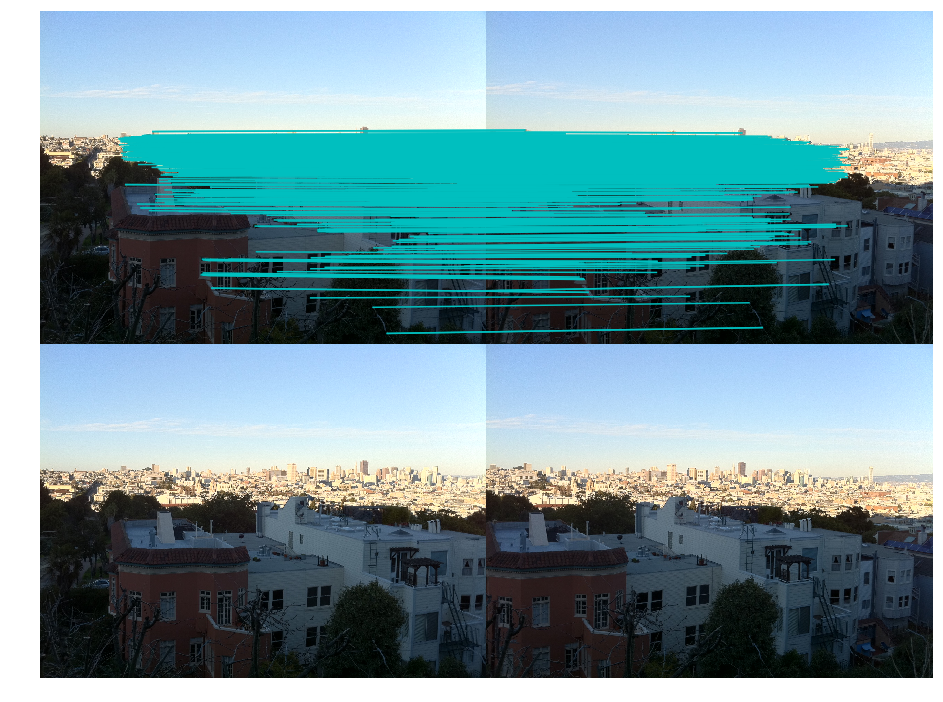

In [6]:
figure(figsize=(16,16))
sift.plot_matches(im1, im2, l1, l2, matches, True)
show()

In [187]:
#def F_from_ransac(x1, x2, model, maxiter=5000, match_threshold=1e-6):
def F_from_ransac(x1, x2, model, maxiter=5000, match_threshold=1e-6):
    """ Robust estimation of a fundamental matrix F from point
    correspondences using RANSAC (ransac.py from
    http://www.scipy.org/Cookbook/RANSAC).

    input: x1, x2 (3*n arrays) points in hom. coordinates. """

    import ransac
    data = np.vstack((x1, x2))
    d = 20 # 20 is the original
    # compute F and return with inlier index
    F, ransac_data = ransac.ransac(data.T, model,
                                   8, maxiter, match_threshold, d, return_all=True)
    return F, ransac_data['inliers']

In [195]:
# find E through RANSAC
model = sfm.RansacModel()
F, inliers = F_from_ransac(x1n, x2n, model, maxiter=5000, match_threshold=1e-3)

In [196]:
print len(x1n[0])
print len(inliers)

1374
116


In [197]:
P1 = array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2 = sfm.compute_P_from_fundamental(F)

In [198]:
# triangulate inliers and remove points not in front of both cameras
X = sfm.triangulate(x1n[:, inliers], x2n[:, inliers], P1, P2)

In [199]:
# plot the projection of X
cam1 = camera.Camera(P1)
cam2 = camera.Camera(P2)
x1p = cam1.project(X)
x2p = cam2.project(X)

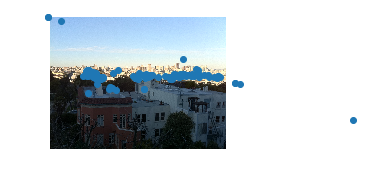

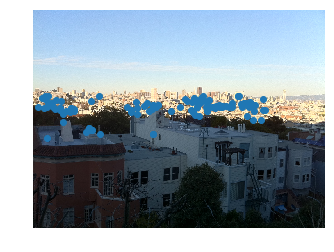

In [200]:
figure()
imshow(im1)
gray()
plot(x1p[0], x1p[1], 'o')
#plot(x1[0], x1[1], 'r.')
axis('off')

figure()
imshow(im2)
gray()
plot(x2p[0], x2p[1], 'o')
#plot(x2[0], x2[1], 'r.')
axis('off')
show()

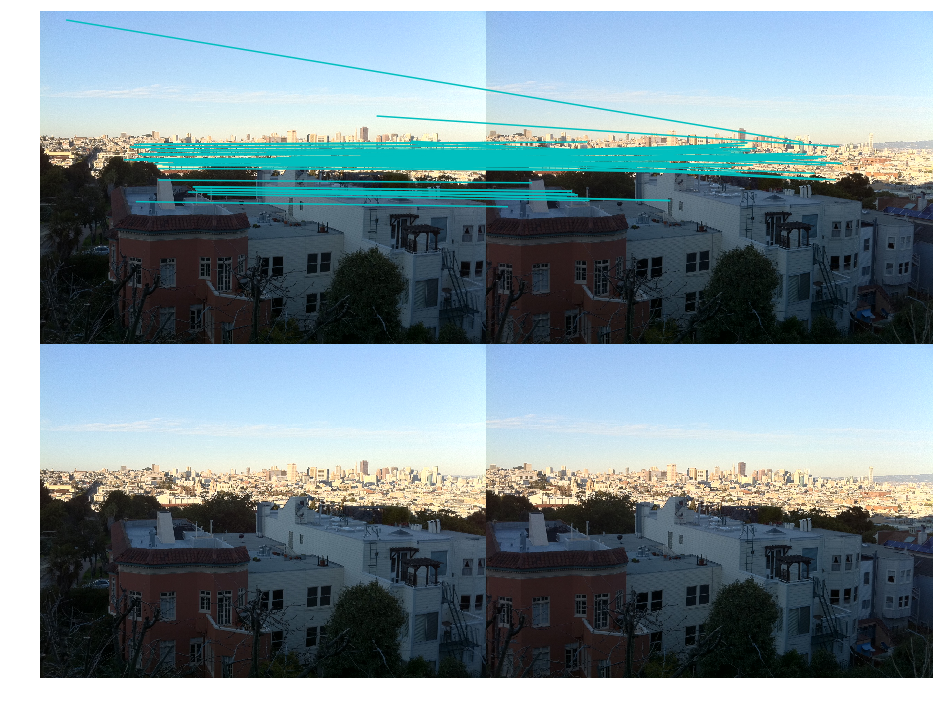

In [201]:
figure(figsize=(16, 16))
im3 = sift.appendimages(im1, im2)
im3 = vstack((im3, im3))

imshow(im3)

cols1 = im1.shape[1]
rows1 = im1.shape[0]
for i in range(len(x1p[0])):
    if (0<= x1p[0][i]<cols1) and (0<= x2p[0][i]<cols1) and (0<=x1p[1][i]<rows1) and (0<=x2p[1][i]<rows1):
        plot([x1p[0][i], x2p[0][i]+cols1],[x1p[1][i], x2p[1][i]],'c')
axis('off')
show()